In [4]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 한글 폰트 설정
import matplotlib.font_manager as fm
import matplotlib as mpl

font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('../../data/processedData/processed_uber_data.csv')

In [5]:
def prepare_data(df):
    # 요일을 숫자로 변환 (월요일=0, 일요일=6)
    day_mapping = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
        'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    df['day_num'] = df['day'].map(day_mapping)
    
    # 시간대별 승객 수 집계
    hourly_demand = df.groupby(['hour', 'day_num'])['passenger_count'].count().reset_index()
    print("데이터 전처리 완료")
    print(f"전처리된 데이터 형태: {hourly_demand.shape}")
    return hourly_demand


In [6]:
# 데이터 전처리 실행
hourly_demand = prepare_data(df)

데이터 전처리 완료
전처리된 데이터 형태: (168, 3)


In [7]:
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,distance,fare_per_km,day_num
0,52:06.0,7.5,2015-05-07 19:52:06 Thursday,-73.999817,40.738354,-73.999512,40.723217,1,19,Thursday,5,1.683323,4.455473,3
1,04:56.0,7.7,2009-07-17 20:04:56 Friday,-73.994355,40.728225,-73.994710,40.750325,1,20,Friday,7,2.457590,3.133151,4
2,45:00.0,12.9,2009-08-24 21:45:00 Monday,-74.005043,40.740770,-73.962565,40.772647,1,21,Monday,8,5.036377,2.561365,0
3,22:21.0,5.3,2009-06-26 08:22:21 Friday,-73.976124,40.790844,-73.965316,40.803349,3,8,Friday,6,1.661683,3.189536,4
4,47:00.0,16.0,2014-08-28 17:47:00 Thursday,-73.925023,40.744085,-73.973082,40.761247,5,17,Thursday,8,4.475450,3.575060,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199994,49:00.0,3.0,2012-10-28 10:49:00 Sunday,-73.987042,40.739367,-73.986525,40.740297,1,10,Sunday,10,0.112210,26.735527,6
199995,09:00.0,7.5,2014-03-14 01:09:00 Friday,-73.984722,40.736837,-74.006672,40.739620,1,1,Friday,3,1.875050,3.999893,4
199996,42:00.0,30.9,2009-06-29 00:42:00 Monday,-73.986017,40.756487,-73.858957,40.692588,2,0,Monday,6,12.850319,2.404610,0
199997,56:25.0,14.5,2015-05-20 14:56:25 Wednesday,-73.997124,40.725452,-73.983215,40.695416,1,14,Wednesday,5,3.539715,4.096375,2


In [8]:
# 데이터 분할
X = hourly_demand[['hour', 'day_num']]
y = hourly_demand['passenger_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n데이터 분할 완료:")
print(f"학습 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")


데이터 분할 완료:
학습 데이터 크기: (134, 2)
테스트 데이터 크기: (34, 2)


In [11]:
X_train


,hour,day_num
69,9,6
136,19,3
2,0,2
93,13,2
134,19,1
...,...,...
71,10,1
106,15,1
14,2,0
92,13,1


In [12]:
# Model A: 단순 시계열 (시간만 고려)
model_a = LinearRegression()
X_train_a = X_train[['hour']]
model_a.fit(X_train_a, y_train)
print("\nModel A (단순 시계열) 학습 완료")


Model A (단순 시계열) 학습 완료


In [14]:
# Model B: 복합 요소 고려 (시간, 요일 모두 고려)
model_b = RandomForestRegressor(n_estimators=100, random_state=42)
model_b.fit(X_train, y_train)
print("Model B (복합 요소) 학습 완료")


Model B (복합 요소) 학습 완료


In [15]:
# 예측 수행
y_pred_a = model_a.predict(X_test[['hour']])
y_pred_b = model_b.predict(X_test)

In [16]:
# 모델 평가 함수
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} 성능 평가:")
    print(f"RMSE (평균 제곱근 오차): {rmse:.2f}")
    print(f"MAE (평균 절대 오차): {mae:.2f}")
    print(f"R2 Score (결정계수): {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# 두 모델 평가
results_a = evaluate_model(y_test, y_pred_a, "Model A (단순 시계열)")
results_b = evaluate_model(y_test, y_pred_b, "Model B (복합 요소)")


Model A (단순 시계열) 성능 평가:
RMSE (평균 제곱근 오차): 382.22
MAE (평균 절대 오차): 293.54
R2 Score (결정계수): 0.4888

Model B (복합 요소) 성능 평가:
RMSE (평균 제곱근 오차): 126.05
MAE (평균 절대 오차): 88.70
R2 Score (결정계수): 0.9444


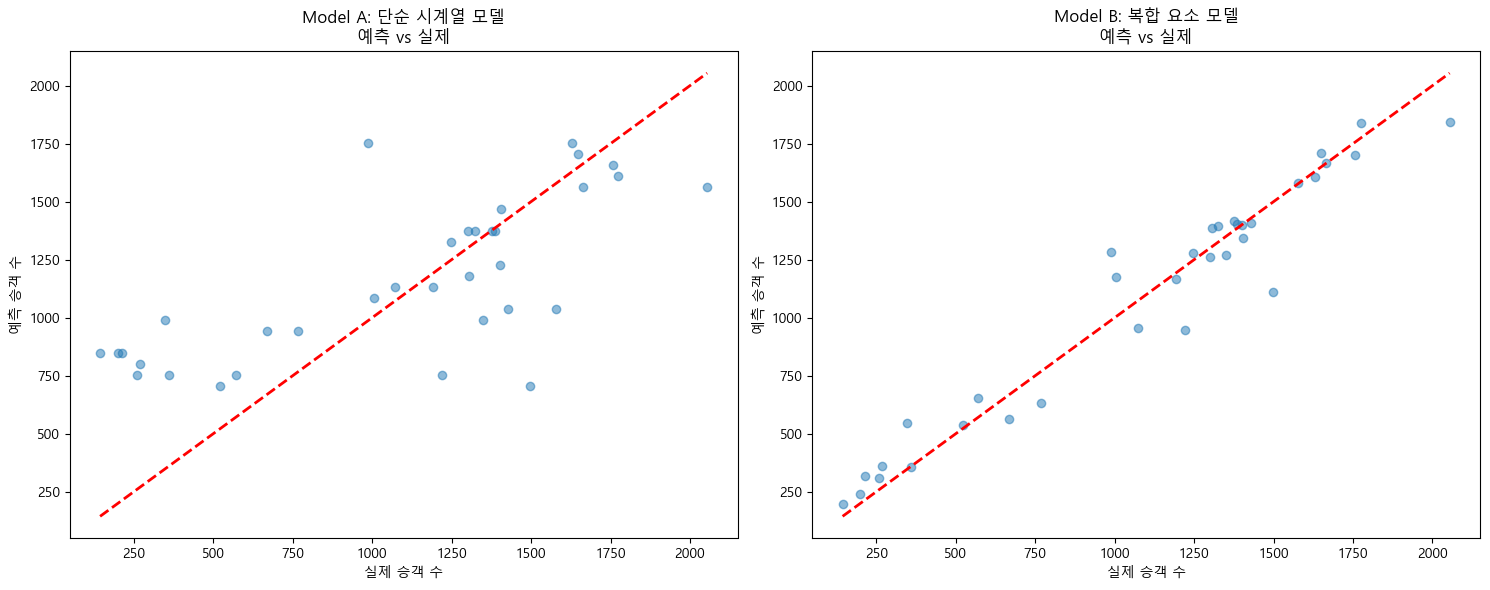

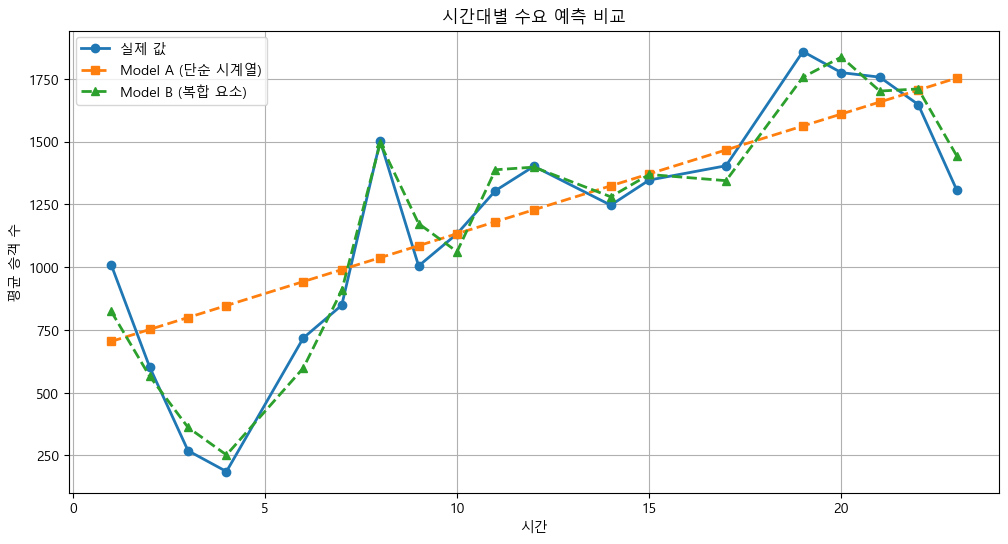

<Figure size 1000x600 with 0 Axes>

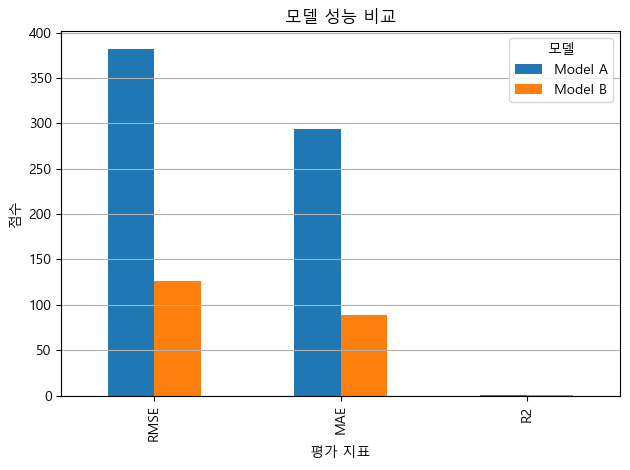


=== A/B 테스트 결과 분석 ===

1. 예측 정확도 비교:
- Model B는 Model A보다 RMSE가 67.0% 개선되었습니다.

2. 모델 특성:
- Model A (단순 시계열):
  * 시간만을 고려한 단순한 모델
  * 구현과 해석이 용이
- Model B (복합 요소):
  * 시간과 요일을 모두 고려한 복잡한 모델
  * 더 정교한 예측 가능

3. 실무 적용 시사점:
- 요일 정보를 추가로 고려하는 것이 예측 정확도 향상에 큰 도움이 됨
- 시간대별 수요 예측에 있어 복합적인 요소를 고려하는 것이 중요


In [17]:
# 1. 예측값 vs 실제값 산점도
plt.figure(figsize=(15, 6))

# Model A 산점도
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_a, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제 승객 수')
plt.ylabel('예측 승객 수')
plt.title('Model A: 단순 시계열 모델\n예측 vs 실제')

# Model B 산점도
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_b, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제 승객 수')
plt.ylabel('예측 승객 수')
plt.title('Model B: 복합 요소 모델\n예측 vs 실제')

plt.tight_layout()
plt.show()

# 2. 시간대별 예측 비교
plt.figure(figsize=(12, 6))
test_df = pd.DataFrame({
    'Hour': X_test['hour'],
    'Actual': y_test,
    'Model A': y_pred_a,
    'Model B': y_pred_b
})
test_df_mean = test_df.groupby('Hour').mean()

plt.plot(test_df_mean.index, test_df_mean['Actual'], 'o-', label='실제 값', linewidth=2)
plt.plot(test_df_mean.index, test_df_mean['Model A'], 's--', label='Model A (단순 시계열)', linewidth=2)
plt.plot(test_df_mean.index, test_df_mean['Model B'], '^--', label='Model B (복합 요소)', linewidth=2)
plt.xlabel('시간')
plt.ylabel('평균 승객 수')
plt.title('시간대별 수요 예측 비교')
plt.legend()
plt.grid(True)
plt.show()

# 3. 모델 성능 비교 막대 그래프
plt.figure(figsize=(10, 6))
metrics = pd.DataFrame({
    'Model A': [results_a['RMSE'], results_a['MAE'], results_a['R2']],
    'Model B': [results_b['RMSE'], results_b['MAE'], results_b['R2']]
}, index=['RMSE', 'MAE', 'R2'])

metrics.plot(kind='bar')
plt.title('모델 성능 비교')
plt.xlabel('평가 지표')
plt.ylabel('점수')
plt.legend(title='모델')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 결과 해석 출력
print("\n=== A/B 테스트 결과 분석 ===")
print("\n1. 예측 정확도 비교:")
improvement_rmse = ((results_a['RMSE'] - results_b['RMSE']) / results_a['RMSE']) * 100
print(f"- Model B는 Model A보다 RMSE가 {improvement_rmse:.1f}% 개선되었습니다.")

print("\n2. 모델 특성:")
print("- Model A (단순 시계열):")
print("  * 시간만을 고려한 단순한 모델")
print("  * 구현과 해석이 용이")
print("- Model B (복합 요소):")
print("  * 시간과 요일을 모두 고려한 복잡한 모델")
print("  * 더 정교한 예측 가능")

print("\n3. 실무 적용 시사점:")
print("- 요일 정보를 추가로 고려하는 것이 예측 정확도 향상에 큰 도움이 됨")
print("- 시간대별 수요 예측에 있어 복합적인 요소를 고려하는 것이 중요")